In [9]:
# Data: time-serie data from smartwatch or smartwatch data
# %matplotlib inline # for plt.show()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
# data_path = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
# data_path = 'data/financial_data/USD_INR.csv'
data_path = 'data/bike_data/hour.csv'
data = pd.read_csv(data_path)

# Showing the data file csv or comma separated value
data[:10]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


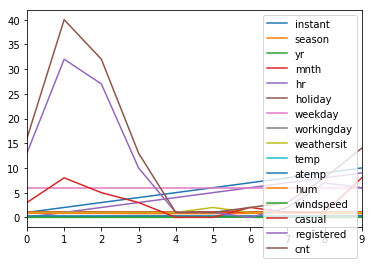

In [10]:
# Data: cleaning
# Getting rid of NaN
data = data.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
# data[:10000]['Price'].plot()
data[: 10].plot()
plt.legend()
plt.show()

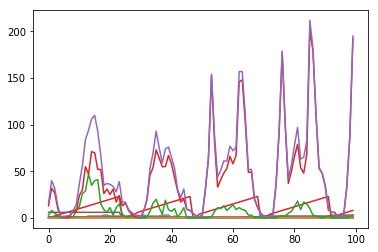

In [11]:
data_array = np.array(data)
data_array.shape, data_array.dtype
data_main = np.array(data_array[:, 2:], dtype=float)
data_main.shape, data_main.dtype

plt.plot(data_main[:100])
plt.show()

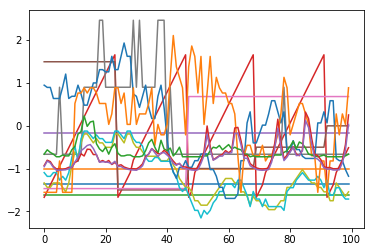

(-2.0933188371550222e-17,
 0.99999999999999978,
 0.99999999999999967,
 (17379, 15),
 dtype('float64'))

In [12]:
mean = np.mean(data_main, axis=0)
std = np.std(data_main, axis=0)
std.shape, mean.shape, std.dtype, mean.dtype

data_norm = (data_main - mean) / std
plt.plot(data_norm[:100])
plt.show()
data_norm.mean(), data_norm.std(), data_norm.var(), data_norm.shape, data_norm.dtype

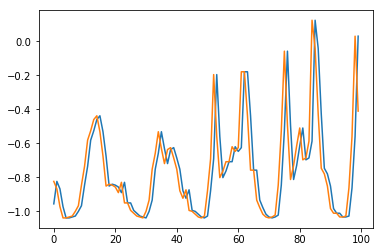

In [13]:
train_data = data_norm[:16000, -1] # the last dim/variable/feature
test_data = data_norm[16000:, -1] # the last dim/variable/feature
train_data.shape, test_data.shape
X_train = train_data[0:15999]
Y_train = train_data[1:16000]
X_train.shape, Y_train.shape

plt.plot(X_train[:100])
plt.plot(Y_train[:100])
plt.show()

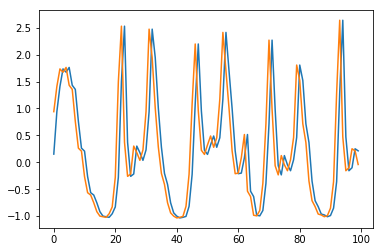

In [14]:
X_valid = test_data[0:1378] 
Y_valid = test_data[1:1379]
X_valid.shape, Y_valid.shape
plt.plot(X_valid[:100])
plt.plot(Y_valid[:100])
plt.show()

In [21]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, p_dropout, lam):
        self.D = D
        self.H = H
        self.p_dropout = p_dropout
        self.lam = lam
        self.losses = {'train':[], 'smooth train':[], 'valid': []}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = [] # from left to right
        for _ in range(2):
            self.model.append(m) # bidirectional: from right to left
        
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X = np.column_stack((hr * h_in, X_in))
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        h = ((1. - hz) * h_in) + (hz * hh)
        # or
        # h = h_in + hz (hh - h_in)

        y, y_cache = l.fc_forward(h, Wy, by)
        
        cache = (h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, 
                 y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        dhh = hz * dh
        dhz = (hh * dh) - (h_in * dh)
        # or
        # dhz = (hh - h_in) * dh

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh = dXh[:, :self.H]
        dX_in2 = dXh[:, self.H:]
        dh_in2 = hr * dh

        dhr = h_in * dh
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_in3 = dX[:, :self.H]
        dX_in1 = dX[:, self.H:]

        dh = dh_in1 + dh_in2 + dh_in3
        dX = dX_in1 + dX_in2

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches, do_caches = [], [], []
        for _ in range(2):
            ys.append([])
            caches.append([])
            do_caches.append([])

        # Left to right
        for X in X_train:
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model[0])
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            caches[0].append(cache)
            do_caches[0].append(do_cache)
            ys[0].append(y)
        
        # Bidirectional: right to left
        for X in reversed(X_train):
            X = X.reshape(1, -1) # X_1xn
            y, h, cache = self.forward(X, h, self.model[1])
            y, do_cache = l.dropout_forward(y, self.p_dropout)
            caches[1].append(cache)
            do_caches[1].append(do_cache)
            ys[1].append(y)
            
        # ys_2xtx1xn
        ys = (np.array(ys[0], dtype=float) + np.array(ys[1], dtype=float))/ 2 # ys_1xtx1xn
        ys = ys.reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        
        return ys, caches, do_caches
                                
    def loss_function(self, y_pred, y_train): # , alpha alpha: learning rate
        loss, dys = 0.0, []

        for y, Y in zip(y_pred, y_train): # both self.model[0] & [1] have equal structure or key elements!
            loss += l2_regression_reg(model=self.model[0], y_pred=y, y_train=Y, lam=self.lam)
            dy = dl2_regression(y_pred=y, y_train=Y)
            dys.append(dy)
            
        return loss, dys # this would be fed into both RNNs directions: l2r & r2l
    
    def train_backward(self, dys, caches, do_caches):
        dh = np.zeros((1, self.H)) 
        grad = {key: np.zeros_like(val) for key, val in self.model[0].items()} # for both is the same
        grads = []
        
        # Gradient for bi-directional RNN or the both-direction of RNN
        for _ in range(2):
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Left to right: backward
        for t in reversed(range(len(dys))):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[0][t])
            _, dh, grad = self.backward(dy, dh, caches[0][t])
            for key in grad.keys():
                grads[0][key] += grad[key]
                
        # Right to left: backward
        for t in range(len(dys)):
            dy = dys[t].reshape(1, -1) # dy_1xn
            dy = l.dropout_backward(dy, do_caches[1][t])
            _, dh, grad = self.backward(dy, dh, caches[1][t])
            for key in grad.keys():
                grads[1][key] += grad[key]
                
        return grads
    
    def test(self, X_seed, h, size):
        ys = []
        for _ in range(2):
            ys.append([])
            
        X = X_seed.reshape(1, -1)
        
        # Left to right
        for _ in range(size):
            y, h, _ = self.forward(X, h, self.model[0])
            X = y.copy() # previous out for the next input for prediction
            ys[0].append(y) # list array
        
        # Right to left
        for _ in reversed(range(size)):
            y, h, _ = self.forward(X, h, self.model[1])
            X = y.copy() # previous out for the next input for prediction
            ys[1].append(y) # list array
            
        # ys_2xtx1xn
        ys = (np.array(ys[0], dtype=float) + np.array(ys[1], dtype=float))/ 2 # ys_1xtx1xn
        ys = ys.reshape(len(ys), -1) # ys_txn instead of ys_tx1xn
        return ys

In [22]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
    # for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, XY_train, XY_valid, alpha, mb_size, n_iter, print_after):
    X_train, y_train = XY_train
    X_valid, y_valid = XY_valid

    M, R = [], []
    for _ in range(2):
        M.append({key: np.zeros_like(val) for key, val in nn.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in nn.model[0].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Train the model
            X_mini, y_mini = minibatches[idx]
            ys, caches, do_caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_pred=ys, y_train=y_mini) #, alpha=alpha
            grads = nn.train_backward(dys, caches, do_caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)
            
            # Update the model
            for num in range(2):
                for key in grads[num].keys(): #key, value: items
                    M[num][key] = l.exp_running_avg(M[num][key], grads[num][key], beta1)
                    R[num][key] = l.exp_running_avg(R[num][key], grads[num][key]**2, beta2)
                    m_k_hat = M[num][key] / (1. - (beta1 ** iter))
                    r_k_hat = R[num][key] / (1. - (beta2 ** iter))
                    nn.model[num][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the model (by testing)
            ys = nn.test(X_seed=X_valid[0], h=state, size=X_valid.shape[0]) # ys_tx1xn
            valid_loss, _ = nn.loss_function(y_pred=ys, y_train=Y_valid) #, alpha=alpha
            nn.losses['valid'].append(valid_loss)

        # Print the model loss/ error
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.8f}, valid loss: {:.8f}'.format(iter, loss, valid_loss))

    return nn

In [23]:
# Hyper-parameters
time_step = 100 # minibatch size
n_iter = 10 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = 1 # X_train.shape[1] # X_txn
p_dropout = 0.9 # p_dropout == keep_prob: probability of keeping neurons/units
lam = 1e-4 # regularization

# Build the network and learning it or optimizing it using SGD
# def adam_rnn(nn, X_train, y_train, alpha=0.001, mb_size=256, n_iter=2000, print_after=100):
net = GRU(D=num_input_units, H=num_hidden_units, p_dropout=p_dropout, lam=lam) #, L=num_layers, p_dropout=p_dropout

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, XY_train=(X_train, Y_train), XY_valid=(X_valid, Y_valid), alpha=alpha, mb_size=time_step,
         n_iter=n_iter, print_after=print_after)

Iter-1, train loss: 44.15472677, valid loss: 746.52728787
Iter-2, train loss: 50.06329784, valid loss: 713.61807677
Iter-3, train loss: 42.72456316, valid loss: 1062.09810101
Iter-4, train loss: 39.14338142, valid loss: 719.53447270
Iter-5, train loss: 38.64720829, valid loss: 1099.89217439
Iter-6, train loss: 45.29393024, valid loss: 981.54202292
Iter-7, train loss: 41.21620750, valid loss: 1449.21940257
Iter-8, train loss: 43.28736083, valid loss: 1023.20219671
Iter-9, train loss: 40.04591979, valid loss: 1269.12958285
Iter-10, train loss: 38.15410268, valid loss: 950.30378590


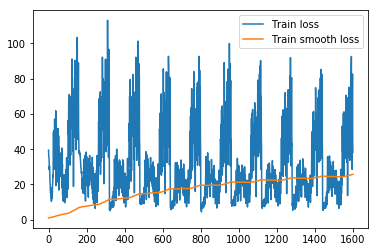

In [24]:
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

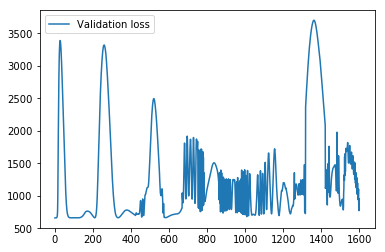

In [25]:
import matplotlib.pyplot as plt

plt.plot(net.losses['valid'], label='Validation loss')
plt.legend()
plt.show()

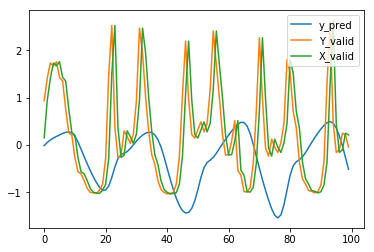

In [26]:
import matplotlib.pyplot as plt

y_pred = net.test(X_seed=X_valid[0], h=net.initial_state(), size=X_valid.shape[0]) # ys_tx1xn
y_pred.shape, Y_valid.shape

plt.plot(y_pred[:100], label='y_pred')
plt.plot(Y_valid[:100], label='Y_valid')
plt.plot(X_valid[:100], label='X_valid')
plt.legend()
plt.show()